In [1]:
##------------------------------------------------------------------------------------------------
## DEMO OF ESTIMATING A PLANET'S ENVELOPE FRACTION USING MESA SIMULATIONS 
# Written by: Sarah Millholland (Yale University, May 2020)

## Dependencies: 
# 1) emcee (https://emcee.readthedocs.io/en/stable/)
# 2) corner.py (https://corner.readthedocs.io/en/latest/, 
#    necessary code already pre-loaded in this directory)

## Outline:
# 1) Define system & planetary parameters.
# 2) Load data of MESA simulations.
# 3) Make an interpolation of the MESA simulations.
# 4) Perform MCMC for case including tidal heating.
# 5) Perform MCMC for case without tidal heating.
# 6) Plot the results.

import numpy as np
from numpy import cos, sin, arccos, arcsin, pi, sqrt, exp
%matplotlib inline
import matplotlib;
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import pdb
import os
import scipy
import scipy.stats as stats
from scipy import interpolate
import emcee
import corner


G = 6.67408*10**(-11)   # gravitational constant 
Mearth = 5.9722*10**24
Rearth = 6.371*10**6
Msun = 1.98911*10**30
Rsun = 6.95*10**8
Mjup = 1.898*10**27
year = 365.25*24*60*60
AU = 149597870700
Teff_sun = 5780. # K

In [2]:
##------------------------------------------------------------------------------------------------
## DEFINE SYSTEM PARAMETERS

# Example: K2-19 c
# Parameters from Petigura et al. (2020)

Mstar = 0.88  # Msun
Rstar = 0.82  # Rsun
Teff = 5322.  # K

P = 7.9222  # d
n = 2*pi/(P*24*60*60)
sqrt_e_cos_omega = 0.02
sqrt_e_sin_omega = -0.44
e = sqrt_e_cos_omega**2 + sqrt_e_sin_omega**2
Rp_obs = 7.0   # Rearth
Rp_obs_err = 0.2
Mp_obs = 32.4  # Mearth
Mp_obs_err = 1.7  # Mearth
a = (1./AU)*((P*24*60*60/(2*pi))**2*G*(Mstar*Msun + Mp_obs*Mearth))**(1./3)  
F_Fearth = Rstar**2*(Teff/Teff_sun)**4*a**(-2.)
log10_F_Fearth = np.log10(F_Fearth)
age_obs = 5.  # Gyr, estimate


# directory to save the MCMC samples in
sys = 'K2-19' 
planet = 'b'
samples_direc = sys + '_' + planet + '_samples/'
if not os.path.exists(samples_direc):
    os.mkdir(samples_direc)



In [3]:
##------------------------------------------------------------------------------------------------
## LOAD MESA SIMULATION DATA
# You must first unzip the data in sim_set_MESA_results.txt.zip.
#
# The simulations provide the planet radius according to two models: one model including tidal 
# heating and one without. The independent variables are the age, planet mass, envelope mass 
# fraction, strength of the incident stellar radiation flux with respect to Earth's, and strength 
# of the tidal dissipation.
# 
# Description of data:
#    sim_index: index of MESA simulation (all rows with the same index
#               correspond to the same simulation)
#    counts_sim: number of ages for each simulation (up to 10, sometimes 
#                less if the simulation went unstable) 
#    age_sim: in Gyr (1, 2, 3, ..., 10 Gyr)
#    orb_sep_sim: semi-major axis (AU)
#    Teq_sim: equilibrium temperature (K)
#    F_Fearth_sim: strength of incident stellar flux with respect to Earth
#                  F_Fearth = orb_sep^(-2) due to use of Solar parameters
#                  in the MESA model
#    Mp_i_sim: initial planet mass (Mearth)
#    f_env_i_sim: initial envelope fraction 
#    Qprime_sim: reduced tidal quality factor
#    Qprime_eps_factor_sim: Gamma parameter, \log_{10}[\frac{Q'(1+\cos^2\epsilon)}{\sin^2\epsilon}]
#    Mp_sim: planet mass at given age in the tides-free model (Mearth)
#    f_env_sim: envelope fraction at given age in the tides-free model 
#    Rp_sim: planet radius at given age in the tides-free model (Rearth)
#    Mp_t_sim: planet mass at given age in the w/ tides model (Mearth)
#    f_env_t_sim: envelope fraction at given age in the w/ tides model
#    Rp_t_sim: planet radius at given age in the w/ tides model (Rearth)


sim_set_filename = 'sim_set_MESA_results.txt'

data = np.genfromtxt(sim_set_filename)
sim_index, counts_sim, age_sim, orb_sep_sim, Teq_sim, F_Fearth_sim, Mp_i_sim, f_env_i_sim, \
    Qprime_sim, Qprime_eps_factor_sim, Mp_sim, f_env_sim, Rp_sim, Mp_t_sim, \
    f_env_t_sim, Rp_t_sim = data.T

reference_ages = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
num_ages = len(reference_ages)

# ratio between radii in the case with tides and the case without tides
Rp_ratio_sim = Rp_t_sim/Rp_sim

# Core mass in case with tides and without tides
Mp_core_t_sim = Mp_t_sim*(1-f_env_t_sim)
Mp_core_sim = Mp_sim*(1-f_env_sim)

# approximate core radii
Rp_core_t_sim = 0.97*Mp_core_t_sim**0.28
Rp_core_sim = 0.97*Mp_core_sim**0.28

In [4]:
##------------------------------------------------------------------------------------------------
## MESA SIMULATION INTERPOLATION 
## Make one function for each age
## Independent variables: mass, envelope fraction, F/Fearth (or Teq), Qprime_eps_factor, age
## Dependent variables: Rp_t_f, Rp_f, Rp_ratio

# No tides
ind_vars = np.array([Mp_sim, np.log10(f_env_sim), np.log10(F_Fearth_sim)]).T
Rp_interp_list = []
# Tides
ind_vars_t = np.array([Mp_t_sim, np.log10(f_env_t_sim), np.log10(Qprime_eps_factor_sim), np.log10(F_Fearth_sim)]).T
Rp_t_interp_list = []
Rp_ratio_interp_list = []

for age_i in reference_ages:
    indices = np.where(age_sim == age_i)[0]
    # No tides
    Rp_interp_list.append(scipy.interpolate.LinearNDInterpolator(ind_vars[indices], Rp_sim[indices]))
    # Tides
    Rp_t_interp_list.append(scipy.interpolate.LinearNDInterpolator(ind_vars_t[indices], Rp_t_sim[indices]))

In [5]:
##------------------------------------------------------------------------------------------------
## MCMC LIKELIHOOD, PRIOR, AND FULL LOG PROBABILITY

## LIKELIHOOD
def lnlike(theta, Rp_obs, Rp_obs_err, interp_func, extra_vars = []):
    # interpolation function called as: interp_func(np.concatenate((theta, extra_vars)()
    ind_vars = np.concatenate((theta, extra_vars))  
    Rp_mod = interp_func([ind_vars])
    if np.isnan(Rp_mod):
        return -np.inf
    else:
        inv_sigma2 = 1.0/(Rp_obs_err**2)
        return -0.5*(np.sum((Rp_obs-Rp_mod)**2*inv_sigma2 - np.log(inv_sigma2)))

## PRIOR
def lnprior(theta, theta_low, theta_high):
    # Uniform 
    if np.all(theta > theta_low) & np.all(theta < theta_high):
        return 0.0
    else:
        return -np.inf

## FULL LOG PROBABILITY
def lnprob(theta, theta_low, theta_high, Rp_obs, Rp_obs_err, interp_func, extra_vars = []):
    lp = lnprior(theta, theta_low, theta_high)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, Rp_obs, Rp_obs_err, interp_func, extra_vars)

/Users/Sarah1/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


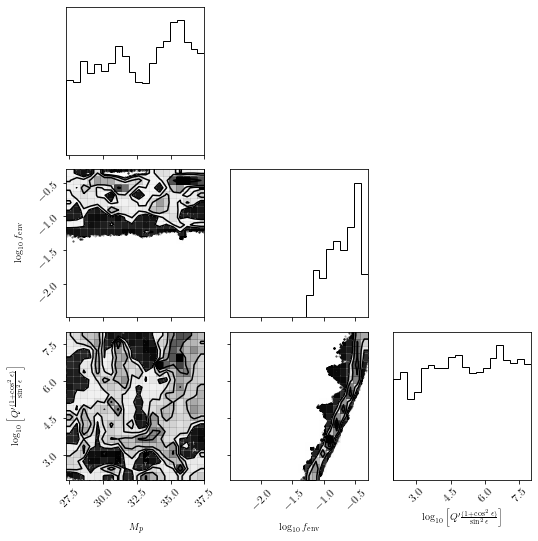

In [6]:
##------------------------------------------------------------------------------------------------
## PERFORM MCMC
## First do case with tides. 
## Then do tides-free case.

# parameter bounds
Mp_low = np.max((Mp_obs - 3*Mp_obs_err, 0))
Mp_high = Mp_obs + 3*Mp_obs_err
log10_f_env_low = -2.5
log10_f_env_high = np.log10(0.5)
log10_Qprime_eps_factor_low = 2. 
log10_Qprime_eps_factor_high = 8.


##------------------------------------------------------------------------------------------------
## PERFORM MCMC -- FIT TO RP_T_F (WITH TIDES)
# pick the interpolation function that matches the age
func_index = np.argmin(np.abs(reference_ages - age_obs))
interp_func = Rp_t_interp_list[func_index]

theta_low = [Mp_low, log10_f_env_low, log10_Qprime_eps_factor_low]
theta_high = [Mp_high, log10_f_env_high, log10_Qprime_eps_factor_high]

## RUN MCMC
# start by initializing the walkers in a Gaussian ball 
ndim, nwalkers = 3, 200
pos = [np.random.uniform(theta_low, theta_high) for i in range(nwalkers)]

# set up the sampler
extra_vars = [log10_F_Fearth]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (theta_low, theta_high, Rp_obs, Rp_obs_err, interp_func, extra_vars))
sampler.run_mcmc(pos, 10000)
samples_t = sampler.chain[:, 5000:, :].reshape((-1, ndim))

# Remove samples that fall outside of the bounds
samples_t = samples_t[np.all((samples_t > theta_low) & (samples_t < theta_high), axis = 1)]

# retrieve samples
Mp_samples_t, log10_f_env_samples_t, log10_Qprime_eps_factor_samples_t = samples_t.T
Qprime_eps_factor_samples_t = 10**log10_Qprime_eps_factor_samples_t
Rp_mod_samples_t = interp_func(Mp_samples_t, log10_f_env_samples_t, log10_Qprime_eps_factor_samples_t, \
                                 np.ones(len(samples_t))*log10_F_Fearth)

# save samples
np.savetxt(samples_direc + 'samples_t.txt', samples_t)

# corner plot
fig = corner.corner(samples_t, labels=[r'$M_p$', r'$\log_{10}f_{\mathrm{env}}$', r'$\log_{10}\left[Q^{\prime}\frac{(1+\cos^2\epsilon)}{\sin^2\epsilon}\right]$'],
                    range = ((Mp_low, Mp_high), (log10_f_env_low, log10_f_env_high), (log10_Qprime_eps_factor_low, log10_Qprime_eps_factor_high)))
for ax in fig.get_axes():  
    ax.tick_params(axis='both', labelsize = 12)
plt.tight_layout()
plt.savefig(samples_direc + 'corner_t.pdf', dpi = 100)

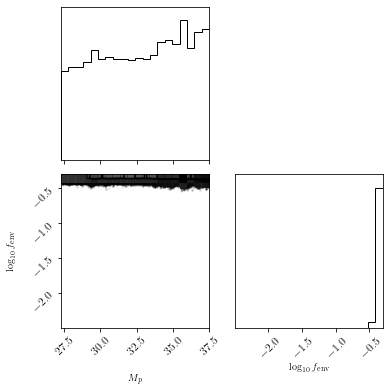

In [7]:
##------------------------------------------------------------------------------------------------
## PERFORM MCMC -- FIT TO RP_F (NO TIDES)
# pick the interpolation function that matches the age
func_index = np.argmin(np.abs(reference_ages - age_obs))
interp_func = Rp_interp_list[func_index]

theta_low = [Mp_low, log10_f_env_low]
theta_high = [Mp_high, log10_f_env_high]


## RUN MCMC
# start by initializing the walkers in a Gaussian ball 
ndim, nwalkers = 2, 200
pos = [np.random.uniform(theta_low, theta_high) for i in range(nwalkers)]

# set up the sampler
extra_vars = [log10_F_Fearth]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(theta_low, theta_high, Rp_obs, Rp_obs_err, interp_func, extra_vars))
sampler.run_mcmc(pos, 10000)
samples = sampler.chain[:, 5000:, :].reshape((-1, ndim))

# Remove samples that fall outside of the bounds
samples = samples[np.all((samples > theta_low) & (samples < theta_high), axis = 1)]

# retrieve samples
Mp_samples, log10_f_env_samples = samples.T
Rp_mod_samples = interp_func(Mp_samples, log10_f_env_samples, np.ones(len(samples))*log10_F_Fearth)

# save samples
np.savetxt(samples_direc + 'samples.txt', samples)

# corner plot
fig = corner.corner(samples, labels=[r'$M_p$',  r'$\log_{10}f_{\mathrm{env}}$'],
                range = ((Mp_low, Mp_high), (log10_f_env_low, log10_f_env_high)))
for ax in fig.get_axes():  
    ax.tick_params(axis='both', labelsize = 12)
plt.tight_layout()
plt.savefig(samples_direc + 'corner.pdf', dpi = 100)

f_env_0 =  44.2+/-2.8


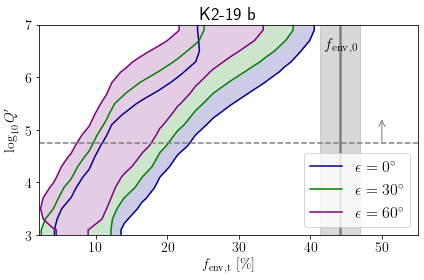

In [8]:
##------------------------------------------------------------------------------------------------
## PLOT BOTH RESULTS (WITH AND WITHOUT TIDES) IN A CORNER PLOT

fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)

## LOAD SAMPLES
samples = np.genfromtxt(samples_direc + 'samples.txt')
Mp_samples, log10_f_env_samples = samples.T 
samples_t = np.genfromtxt(samples_direc + 'samples_t.txt')
Mp_samples_t, log10_f_env_samples_t, log10_Qprime_eps_factor_samples_t = samples_t.T
Qprime_eps_factor_samples_t = 10**log10_Qprime_eps_factor_samples_t


##------------------------------------------------------------------------
## TRANSFORM SAMPLES TO CORRECT Q' USING EQUATION 8 OF MILLHOLLAND ET AL. (2020)
# Obliquity tides -- code uses Teff = Teff_sun, Rstar = Rsun
a_orig = F_Fearth**(-1./2)
P_orig = 2*pi*sqrt((a_orig*AU)**3/(G*(Msun + Mp_obs*Mearth)))
n_orig = 2*pi/P_orig  # in 1/sec

# Eccentricity tides
Omega = (1+3*e**2+(3./8)*e**4)/(1-e**2)**4.5   # Levrard et al. (2007) equation 2
Omegae = (1+(3./2)*e**2+(1./8)*e**4)/(1-e**2)**5 # Leconte et al. (2010) equation 7
N = (1+7.5*e**2+(45./8)*e**4+(5./16)*e**6)/(1-e**2)**6 # Leconte et al. (2010) equation 3
Na = (1 + (31./2)*e**2 + (255./8)*e**4 + (185./16)*e**6 + (25./64)*e**8)/(1-e**2)**(15./2)
# Leconte et al. (2010) equation 4
Ne = (1+(15./4)*e**2 + (15./8)*e**4 + (5./64)*e**6)/(1-e**2)**(13./2)

eps = 0
log10_Qprime_eff_samples_t_eps0 = np.log10(Qprime_eps_factor_samples_t) + \
    np.log10(Mstar**2*(n/n_orig)*(a_orig/a)**6*(Na - N**2/Omega*2*cos(eps)**2/(1+cos(eps)**2)))
eps = 30*pi/180
log10_Qprime_eff_samples_t_eps30 = np.log10(Qprime_eps_factor_samples_t) + \
    np.log10(Mstar**2*(n/n_orig)*(a_orig/a)**6*(Na - N**2/Omega*2*cos(eps)**2/(1+cos(eps)**2)))
eps = 60*pi/180
log10_Qprime_eff_samples_t_eps60 = np.log10(Qprime_eps_factor_samples_t) + \
    np.log10(Mstar**2*(n/n_orig)*(a_orig/a)**6*(Na - N**2/Omega*2*cos(eps)**2/(1+cos(eps)**2)))


## CALCULATE TIDAL CIRCULARIZATION TIMESCALE
Qprime = 10**4
eps = 0*pi/180
omega_p = n*(N/Omega)*2*cos(eps)/(1 + cos(eps)**2)
Qprime = 10**6
tau_e_1e6 = -(4./99.)*(Mp_obs*Mearth/(Mstar*Msun))*Qprime*(a*AU/(Rp_obs*Rearth))**5*(1./n)*(Omegae*cos(eps)*omega_p/n - (18./11)*Ne)**(-1.)
tau_e_1e6 = tau_e_1e6/(365.25*24*60*60)

Qprime_tau_e_1e9 = 1e9/(tau_e_1e6/(Qprime))


##------------------------------------------------------------------------
## PLOT WITH TIDES
# parameter bounds
log10_f_env_low = -2.5
log10_f_env_high = np.log10(0.5)
log10_Qprime_eps_factor_low = 3.
log10_Qprime_eps_factor_high = 7.


smooth = 1.
corner.hist2d(10**log10_f_env_samples_t*100, log10_Qprime_eff_samples_t_eps0, \
                    labels=[r'$\log_{10}f_{\mathrm{env}}$', r'$\log_{10}Q^{\prime}$'],
                    range = ((10**log10_f_env_low*100, 10**log10_f_env_high*100), (log10_Qprime_eps_factor_low, log10_Qprime_eps_factor_high)), \
                    color = 'darkblue', smooth = smooth, fill_contours = True, plot_datapoints = False, \
                    levels = 1.0 - np.exp(-0.5 * np.arange(2.0, 2.1, 0.5) ** 2))
corner.hist2d(10**log10_f_env_samples_t*100, log10_Qprime_eff_samples_t_eps30, \
                    labels=[r'$\log_{10}f_{\mathrm{env}}$', r'$\log_{10}Q^{\prime}$'],
                    range = ((10**log10_f_env_low*100, 10**log10_f_env_high*100), (log10_Qprime_eps_factor_low, log10_Qprime_eps_factor_high)), \
                    color = 'g', smooth = smooth, fill_contours = True, plot_datapoints = False, \
                    levels = 1.0 - np.exp(-0.5 * np.arange(2.0, 2.1, 0.5) ** 2))
corner.hist2d(10**log10_f_env_samples_t*100, log10_Qprime_eff_samples_t_eps60, \
                    labels=[r'$\log_{10}f_{\mathrm{env}}$', r'$\log_{10}Q^{\prime}$'],
                    range = ((10**log10_f_env_low*100, 10**log10_f_env_high*100), (log10_Qprime_eps_factor_low, log10_Qprime_eps_factor_high)), \
                    color = 'purple', smooth = smooth, fill_contours = True, plot_datapoints = False, \
                    levels = 1.0 - np.exp(-0.5 * np.arange(2.0, 2.1, 0.5) ** 2))

plt.plot((0,0), (0,1), color = 'darkblue', label = r'$\epsilon = 0^{\circ}$')
plt.plot((0,0), (0,1), color = 'g', label = r'$\epsilon = 30^{\circ}$')
plt.plot((0,0), (0,1), color = 'purple', label = r'$\epsilon = 60^{\circ}$')
plt.legend(fontsize = 16, loc = 'lower right')

mean = np.mean(10**log10_f_env_samples*100)
sigma = np.std(10**log10_f_env_samples*100)
print ('f_env_0 = ', str(np.round(mean, 1)) + '+/-' + str(np.round(sigma, 1)))
plt.axvline(mean, color = 'gray', linewidth = 2.5)
plt.axvspan(mean-sigma, mean+sigma, alpha = 0.3, color = 'gray')
t = plt.text(mean, 6.5, r'$f_{\mathrm{env, 0}}$', color = 'k', fontsize = 16, ha = 'center')

plt.axhline(np.log10(Qprime_tau_e_1e9), color = 'gray', linestyle = 'dashed')
plt.annotate('', xy = (50, np.log10(Qprime_tau_e_1e9) + 0.5), xytext = (50, np.log10(Qprime_tau_e_1e9)), \
     arrowprops = dict(arrowstyle = '->', color = 'gray'), verticalalignment = 'center', fontsize = 16, color = 'gray')

plt.title(sys + ' ' + planet, fontsize = 18)

ax.tick_params(axis = 'both', labelsize = 14)
plt.xlim(2, 55) 
ax.set_xticks([10,  20,  30, 40,  50])
plt.ylim(3,7)
ax.set_yticks([3, 4, 5, 6, 7])
 
ax.set_xlabel(r'$f_{\mathrm{env, t}} \ [\%]$', fontsize = 14)
ax.set_ylabel(r'$\log_{10}Q^{\prime}$', fontsize = 14)

plt.tight_layout()
plt.savefig(samples_direc + 'fit.pdf', dpi = 100)